<a href="https://colab.research.google.com/github/chandresh33/Docs/blob/master/wbanet_IPCM_August_2024_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pip install einops

In [ ]:
# pip install timm

In [ ]:
# !pip install PyWavelets

In [ ]:
# preclassification

import numpy as np
from scipy import signal
from scipy.linalg import norm
from scipy.spatial.distance import cdist


def del2(im):
    [ylen, xlen] = im.shape
    im_new = np.zeros([ylen, xlen], dtype=np.float32)
    for j in range(1, ylen - 1):
        for i in range(1, xlen - 1):
            im_new[j, i] = (im[j - 1, i] + im[j + 1, i] + im[j, i - 1] + im[j, i + 1]) / 4 - im[j, i]
    return im_new


def srad(im, delta):
    q0 = 1
    for n in range(1, 6):
        [ylen, xlen] = im.shape
        X = np.zeros([ylen + 2, xlen + 2], dtype=np.float32)
        X[1:ylen + 1, 1:xlen + 1] = im
        # padding
        X[0, 1:xlen + 1] = im[0, :]
        X[ylen + 1, 1:xlen + 1] = im[ylen - 1, :]
        X[:, 0] = X[:, 1]
        X[:, xlen + 1] = X[:, xlen]

        q0 = q0 * np.exp(-delta)
        gRx = signal.convolve2d(X, [[0, 0, 0], [0, 1, -1], [0, 0, 0]], mode='same', boundary='symm')
        gRy = signal.convolve2d(X, [[0, -1, 0], [0, 1, 0], [0, 0, 0]], mode='same', boundary='symm')
        gLx = signal.convolve2d(X, [[0, 0, 0], [1, -1, 0], [0, 0, 0]], mode='same', boundary='symm')
        gLy = signal.convolve2d(X, [[0, 0, 0], [0, -1, 0], [0, 1, 0]], mode='same', boundary='symm')
        q1 = np.sqrt(gRx * gRx + gRy * gRy + gLx * gLx + gLy * gLy) / (X + 0.0001)
        q2 = 4 * del2(X) / (X + 0.0001)
        q = np.sqrt((1 / 2 * (q1 * q1) - 1 / 16 * (q2 * q2)) / ((1 + 1 / 4 * q2) * (1 + 1 / 4 * q2) + 0.01))
        c = 1 / (1 + ((q * q - q0 * q0) / (q0 * q0 * (1 + q0 * q0))))
        d = signal.convolve2d(c, [[0, 0, 0], [0, 0, -1], [0, 0, 0]], mode='same', boundary='symm') * \
            signal.convolve2d(X, [[0, 0, 0], [0, 1, -1], [0, 0, 0]], mode='same', boundary='symm') + \
            signal.convolve2d(c, [[0, 0, 0], [0, -1, 0], [0, 0, 0]], mode='same', boundary='symm') * \
            signal.convolve2d(X, [[0, 0, 0], [-1, 1, 0], [0, 0, 0]], mode='same', boundary='symm') + \
            signal.convolve2d(c, [[0, -1, 0], [0, 0, 0], [0, 0, 0]], mode='same', boundary='symm') * \
            signal.convolve2d(X, [[0, -1, 0], [0, 1, 0], [0, 0, 0]], mode='same', boundary='symm') + \
            signal.convolve2d(c, [[0, 0, 0], [0, -1, 0], [0, 0, 0]], mode='same', boundary='symm') * \
            signal.convolve2d(X, [[0, 0, 0], [0, 1, 0], [0, -1, 0]], mode='same', boundary='symm')
        X = X + delta / 4 * d
        im = X[1:ylen + 1, 1:xlen + 1]
    return im


def dicomp(im1, im2):
    im1 = srad(im1, 0.15)
    im2 = srad(im2, 0.15)
    im_di = abs(np.log((im1 + 1) / (im2 + 1)))
    im_di = srad(im_di, 0.15)
    return im_di
    # im1-im2


# hiearchical FCM clustering
# in the preclassification map,
# pixels with high probability to be unchanged are labeled 1
# pixels with high probability to be changed are labeled 2
# pixels with uncertainty are labeled 1.5

def hcluster(pix_vec, im_di):
    print('... ... 1st round clustering ... ...')
    fcm = FCM(n_clusters=2)
    fcm.fit(pix_vec)
    fcm_lab = fcm.u.argmax(axis=1)

    # 变化类像素数目的上下界
    if sum(fcm_lab == 0) < sum(fcm_lab == 1):
        ttr = round(sum(fcm_lab == 0) * 1.25)
        ttl = round(sum(fcm_lab == 0) / 1.10)
    else:
        ttr = round(sum(fcm_lab == 1) * 1.25)
        ttl = round(sum(fcm_lab == 1) / 1.10)

    print('... ... 2nd round clustering ... ...')
    fcm = FCM(n_clusters=5)
    fcm.fit(pix_vec)
    fcm_lab = fcm.u.argmax(axis=1)
    ylen, xlen = im_di.shape
    idx = []
    idx_tmp = []
    idxmean = []
    res_lab = np.zeros(ylen * xlen, dtype=np.float32)
    for i in range(0, 5):
        idx_tmp.append(np.argwhere(fcm_lab == i))
        idxmean.append(im_di.reshape(ylen * xlen, 1)[idx_tmp[i]].mean())

    idx_sort = np.argsort(idxmean)
    for i in range(0, 5):
        idx.append(idx_tmp[idx_sort[i]])
    c = len(idx[4])
    res_lab[idx[4]] = 2
    flag_mid = 0
    for i in range(1, 5):
        c = c + len(idx[4 - i])
        if c < ttl:
            res_lab[idx[4 - i]] = 2
        elif c >= ttl and c < ttr:
            res_lab[idx[4 - i]] = 1.5
            flag_mid = 1
        elif flag_mid == 0:
            res_lab[idx[4 - i]] = 1.5
            flag_mid = 1
        else:
            res_lab[idx[4 - i]] = 1
    res_lab = res_lab.reshape(ylen, xlen)
    return res_lab


class FCM:
    def __init__(self, n_clusters=10, max_iter=150, m=2, error=1e-5, random_state=42):
        self.u, self.centers = None, None
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.m = m
        self.error = error
        self.random_state = random_state

    def fit(self, X):
        N = X.shape[0]
        C = self.n_clusters
        centers = []
        r = np.random.RandomState(self.random_state)
        u = r.rand(N, C)
        u = u / np.tile(u.sum(axis=1)[np.newaxis].T, C)
        iteration = 0
        while iteration < self.max_iter:
            u2 = u.copy()
            centers = self.next_centers(X, u)
            u = self.next_u(X, centers)
            iteration += 1
            # Stopping rule
            if norm(u - u2) < self.error:
                break
        self.u = u
        self.centers = centers
        return self

    def next_centers(self, X, u):
        um = u ** self.m
        return (X.T @ um / np.sum(um, axis=0)).T

    def next_u(self, X, centers):
        return self._predict(X, centers)

    def _predict(self, X, centers):
        power = float(2 / (self.m - 1))
        temp = cdist(X, centers) ** power
        denominator_ = temp.reshape((X.shape[0], 1, -1)).repeat(temp.shape[-1], axis=1)
        denominator_ = temp[:, :, np.newaxis] / denominator_
        return 1 / denominator_.sum(2)

    def predict(self, X):
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)
        u = self._predict(X, self.centers)
        return np.argmax(u, axis=-1)

In [ ]:
#wbanet
import time
import pywt
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
from torch.autograd import Variable, gradcheck


class DWT_Function(Function):
    @staticmethod
    def forward(ctx, x, w_ll, w_lh, w_hl, w_hh):
        x = x.contiguous()
        ctx.save_for_backward(w_ll, w_lh, w_hl, w_hh)
        ctx.shape = x.shape

        dim = x.shape[1]
        x_ll = torch.nn.functional.conv2d(x, w_ll.expand(dim, -1, -1, -1), stride=2, groups=dim)
        x_lh = torch.nn.functional.conv2d(x, w_lh.expand(dim, -1, -1, -1), stride=2, groups=dim)
        x_hl = torch.nn.functional.conv2d(x, w_hl.expand(dim, -1, -1, -1), stride=2, groups=dim)
        x_hh = torch.nn.functional.conv2d(x, w_hh.expand(dim, -1, -1, -1), stride=2, groups=dim)
        x = torch.cat([x_ll, x_lh, x_hl, x_hh], dim=1)
        return x

    @staticmethod
    def backward(ctx, dx):
        if ctx.needs_input_grad[0]:
            w_ll, w_lh, w_hl, w_hh = ctx.saved_tensors
            B, C, H, W = ctx.shape
            dx = dx.view(B, 4, -1, H // 2, W // 2)

            dx = dx.transpose(1, 2).reshape(B, -1, H // 2, W // 2)
            filters = torch.cat([w_ll, w_lh, w_hl, w_hh], dim=0).repeat(C, 1, 1, 1)
            dx = torch.nn.functional.conv_transpose2d(dx, filters, stride=2, groups=C)

        return dx, None, None, None, None

class IDWT_Function(Function):
    @staticmethod
    def forward(ctx, x, filters):
        ctx.save_for_backward(filters)
        ctx.shape = x.shape

        B, _, H, W = x.shape
        x = x.view(B, 4, -1, H, W).transpose(1, 2)
        C = x.shape[1]
        x = x.reshape(B, -1, H, W)
        filters = filters.repeat(C, 1, 1, 1)
        x = torch.nn.functional.conv_transpose2d(x, filters, stride=2, groups=C)
        return x

    @staticmethod
    def backward(ctx, dx):
        if ctx.needs_input_grad[0]:
            filters = ctx.saved_tensors
            filters = filters[0]
            B, C, H, W = ctx.shape
            C = C // 4
            dx = dx.contiguous()

            w_ll, w_lh, w_hl, w_hh = torch.unbind(filters, dim=0)
            x_ll = torch.nn.functional.conv2d(dx, w_ll.unsqueeze(1).expand(C, -1, -1, -1), stride=2, groups=C)
            x_lh = torch.nn.functional.conv2d(dx, w_lh.unsqueeze(1).expand(C, -1, -1, -1), stride=2, groups=C)
            x_hl = torch.nn.functional.conv2d(dx, w_hl.unsqueeze(1).expand(C, -1, -1, -1), stride=2, groups=C)
            x_hh = torch.nn.functional.conv2d(dx, w_hh.unsqueeze(1).expand(C, -1, -1, -1), stride=2, groups=C)
            dx = torch.cat([x_ll, x_lh, x_hl, x_hh], dim=1)
        return dx, None

class IDWT_2D(nn.Module):
    def __init__(self, wave):
        super(IDWT_2D, self).__init__()
        w = pywt.Wavelet(wave)
        rec_hi = torch.Tensor(w.rec_hi)
        rec_lo = torch.Tensor(w.rec_lo)

        w_ll = rec_lo.unsqueeze(0) * rec_lo.unsqueeze(1)
        w_lh = rec_lo.unsqueeze(0) * rec_hi.unsqueeze(1)
        w_hl = rec_hi.unsqueeze(0) * rec_lo.unsqueeze(1)
        w_hh = rec_hi.unsqueeze(0) * rec_hi.unsqueeze(1)

        w_ll = w_ll.unsqueeze(0).unsqueeze(1)
        w_lh = w_lh.unsqueeze(0).unsqueeze(1)
        w_hl = w_hl.unsqueeze(0).unsqueeze(1)
        w_hh = w_hh.unsqueeze(0).unsqueeze(1)
        filters = torch.cat([w_ll, w_lh, w_hl, w_hh], dim=0)
        self.register_buffer('filters', filters)
        self.filters = self.filters.to(dtype=torch.float16)

    def forward(self, x):
        return IDWT_Function.apply(x, self.filters)

class DWT_2D(nn.Module):
    def __init__(self, wave):
        super(DWT_2D, self).__init__()
        w = pywt.Wavelet(wave)
        dec_hi = torch.Tensor(w.dec_hi[::-1])
        dec_lo = torch.Tensor(w.dec_lo[::-1])

        w_ll = dec_lo.unsqueeze(0) * dec_lo.unsqueeze(1)
        w_lh = dec_lo.unsqueeze(0) * dec_hi.unsqueeze(1)
        w_hl = dec_hi.unsqueeze(0) * dec_lo.unsqueeze(1)
        w_hh = dec_hi.unsqueeze(0) * dec_hi.unsqueeze(1)

        self.register_buffer('w_ll', w_ll.unsqueeze(0).unsqueeze(0))
        self.register_buffer('w_lh', w_lh.unsqueeze(0).unsqueeze(0))
        self.register_buffer('w_hl', w_hl.unsqueeze(0).unsqueeze(0))
        self.register_buffer('w_hh', w_hh.unsqueeze(0).unsqueeze(0))

        self.w_ll = self.w_ll.to(dtype=torch.float16)
        self.w_lh = self.w_lh.to(dtype=torch.float16)
        self.w_hl = self.w_hl.to(dtype=torch.float16)
        self.w_hh = self.w_hh.to(dtype=torch.float16)

    def forward(self, x):
        return DWT_Function.apply(x, self.w_ll, self.w_lh, self.w_hl, self.w_hh)

'''
def test_time(x, dwt1, dwt2):
    loop = 1000
    total_time1 = 0
    total_time2 = 0

    for i in range(loop):
        start = time.time()
        y1 = dwt1(x)
        torch.cuda.synchronize()
        end = time.time()
        total_time1 += end - start

    for i in range(loop):
        start = time.time()
        y2_ll, YH = dwt2(x)
        torch.cuda.synchronize()
        end = time.time()
        total_time2 += end - start

    print(total_time1)
    print(total_time2)

def test_diff(x, dwt1, dwt2):
    y1 = dwt1(x)
    B, C, H, W = y1.shape
    y1 = y1.view(B, 4, -1, H, W)
    y1_ll = y1[:, 0]
    y1_lh = y1[:, 1]
    y1_hl = y1[:, 2]
    y1_hh = y1[:, 3]
    y2_ll, YH = dwt2(x)
    y2_lh = YH[0][:,:,0]
    y2_hl = YH[0][:,:,1]
    y2_hh = YH[0][:,:,2]
    diff1 = (y1_ll - y2_ll).max()
    diff2 = (y1_lh - y2_lh).max()
    diff3 = (y1_hl - y2_hl).max()
    diff4 = (y1_hh - y2_hh).max()
    print(diff1)
    print(diff2)
    print(diff3)
    print(diff4)

def test_idfiff(x, idwt1, idwt2):
    y1 = idwt1(x)

    x = x.view(x.size(0), 4, -1, x.size(-2), x.size(-1))
    y2 = idwt2((x[:, 0], [x[:,1:].transpose(1, 2)]))
    diff = (y1-y2).max()
    print(diff)

def test_itime(x, idwt1, idwt2):
    loop = 1000
    total_time1 = 0
    total_time2 = 0

    for i in range(loop):
        start = time.time()
        y1 = idwt1(x)
        torch.cuda.synchronize()
        end = time.time()
        total_time1 += end - start

    for i in range(loop):
        start = time.time()
        x = x.view(x.size(0), 4, -1, x.size(-2), x.size(-1))
        y2 = idwt2((x[:, 0], [x[:,1:].transpose(1, 2)]))
        torch.cuda.synchronize()
        end = time.time()
        total_time2 += end - start

    print(total_time1)
    print(total_time2)

if __name__ == '__main__':
    #size = (96, 32, 56, 56)
    #size = (96, 64, 28, 28)
    size = (96, 160, 14, 14)
    x = torch.randn(size).cuda().to(dtype=torch.float16)
    dwt1 = DWT_2D('haar').cuda()
    dwt2 = DWTForward(wave='haar').cuda()
    test_diff(x, dwt1, dwt2)
    test_time(x, dwt1, dwt2)

    #size = (96, 32*4, 28, 28)
    #size = (96, 64*4, 14, 14)
    #size = (96, 160*4, 7, 7)
    #x = torch.randn(size).cuda().to(dtype=torch.float16)
    #idwt1 = IDWT_2D('haar').cuda()
    #idwt2 = DWTInverse(wave='haar').cuda()
    #test_idfiff(x, idwt1, idwt2)
    #test_itime(x, idwt1, idwt2)

def test_dwt_grad():
    size = (4, 8, 14, 14)
    x = torch.randn(size).double()

    w = pywt.Wavelet('haar')
    dec_hi = torch.Tensor(w.dec_hi[::-1])
    dec_lo = torch.Tensor(w.dec_lo[::-1])

    w_ll = (dec_lo.unsqueeze(0)*dec_lo.unsqueeze(1)).unsqueeze(0).unsqueeze(0).double()
    w_lh = (dec_lo.unsqueeze(0)*dec_hi.unsqueeze(1)).unsqueeze(0).unsqueeze(0).double()
    w_hl = (dec_hi.unsqueeze(0)*dec_lo.unsqueeze(1)).unsqueeze(0).unsqueeze(0).double()
    w_hh = (dec_hi.unsqueeze(0)*dec_hi.unsqueeze(1)).unsqueeze(0).unsqueeze(0).double()

    input = (
        Variable(x, requires_grad=True),
        Variable(w_ll, requires_grad=False),
        Variable(w_lh, requires_grad=False),
        Variable(w_hl, requires_grad=False),
        Variable(w_hh, requires_grad=False),
    )
    test = gradcheck(DWT_Function.apply, input)
    print("test:", test)

def test_idwt_grad():
    size = (4, 2*8, 7, 7)
    x = torch.randn(size).double()

    w = pywt.Wavelet('haar')
    rec_hi = torch.Tensor(w.rec_hi)
    rec_lo = torch.Tensor(w.rec_lo)

    w_ll = rec_lo.unsqueeze(0)*rec_lo.unsqueeze(1)
    w_lh = rec_lo.unsqueeze(0)*rec_hi.unsqueeze(1)
    w_hl = rec_hi.unsqueeze(0)*rec_lo.unsqueeze(1)
    w_hh = rec_hi.unsqueeze(0)*rec_hi.unsqueeze(1)

    w_ll = w_ll.unsqueeze(0).unsqueeze(1)
    w_lh = w_lh.unsqueeze(0).unsqueeze(1)
    w_hl = w_hl.unsqueeze(0).unsqueeze(1)
    w_hh = w_hh.unsqueeze(0).unsqueeze(1)
    filters = torch.cat([w_ll, w_lh, w_hl, w_hh], dim=0).double()

    input = (
        Variable(x, requires_grad=True),
        Variable(filters, requires_grad=False),
    )
    test = gradcheck(IDWT_Function.apply, input)
    print("test:", test)

if __name__ == "__main__":
    test_dwt_grad()
'''

'\ndef test_time(x, dwt1, dwt2):\n    loop = 1000\n    total_time1 = 0\n    total_time2 = 0\n\n    for i in range(loop):\n        start = time.time()\n        y1 = dwt1(x)\n        torch.cuda.synchronize()\n        end = time.time()\n        total_time1 += end - start\n\n    for i in range(loop):\n        start = time.time()\n        y2_ll, YH = dwt2(x)\n        torch.cuda.synchronize()\n        end = time.time()\n        total_time2 += end - start\n\n    print(total_time1)\n    print(total_time2)\n\ndef test_diff(x, dwt1, dwt2):\n    y1 = dwt1(x)\n    B, C, H, W = y1.shape\n    y1 = y1.view(B, 4, -1, H, W)\n    y1_ll = y1[:, 0]\n    y1_lh = y1[:, 1]\n    y1_hl = y1[:, 2]\n    y1_hh = y1[:, 3]\n    y2_ll, YH = dwt2(x)\n    y2_lh = YH[0][:,:,0]\n    y2_hl = YH[0][:,:,1]\n    y2_hh = YH[0][:,:,2]\n    diff1 = (y1_ll - y2_ll).max()\n    diff2 = (y1_lh - y2_lh).max()\n    diff3 = (y1_hl - y2_hl).max()\n    diff4 = (y1_hh - y2_hh).max()\n    print(diff1)\n    print(diff2)\n    print(diff3)\

In [ ]:
import numpy as np
# from preclassify import dicomp, hcluster
import cv2
import torch
import torch.nn as nn
import time
import numpy as np
from sklearn.manifold import TSNE
from scipy import io as sio
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from einops.layers.torch import Rearrange
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from timm.models.layers import trunc_normal_
from torch.autograd import Function
# from torch_wavelets import DWT_2D, IDWT_2D
import pywt
from skimage import io, measure
import random
import math
from tqdm.notebook import tqdm
import os
from PIL import Image

In [ ]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

seed = 3407

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [ ]:
def image_normalize(data):
    import math
    _mean = np.mean(data)
    _std = np.std(data)
    npixel = np.size(data) * 1.0
    min_stddev = 1.0 / math.sqrt(npixel)
    return (data - _mean) / max(_std, min_stddev)

def image_padding(data, r):
    if len(data.shape) == 3:
        data_new = np.lib.pad(data, ((r, r), (r, r), (0, 0)), 'constant', constant_values=0)
        return data_new
    if len(data.shape) == 2:
        data_new = np.lib.pad(data, r, 'constant', constant_values=0)
        return data_new

def arr(length):
    arr = np.arange(length - 1)
    # print(arr)
    random.shuffle(arr)
    # print(arr)
    return arr

def createTrainingCubes(X, y, patch_size):
    margin = int((patch_size - 1) / 2) + 1
    zeroPaddedX = image_padding(X, margin)
    ele_num1 = np.sum(y == 1)
    ele_num2 = np.sum(y == 2)
    patchesData_1 = np.zeros((ele_num1, patch_size, patch_size, X.shape[2]))
    patchesLabels_1 = np.zeros(ele_num1)
    patchesData_2 = np.zeros((ele_num2, patch_size, patch_size, X.shape[2]))
    patchesLabels_2 = np.zeros(ele_num2)

    patchIndex_1 = 0
    patchIndex_2 = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            # remove uncertainty pixels
            if y[r - margin, c - margin] == 1:
                patch_1 = zeroPaddedX[r - margin:r + margin, c - margin:c + margin]
                patchesData_1[patchIndex_1, :, :, :] = patch_1
                patchesLabels_1[patchIndex_1] = y[r - margin, c - margin]
                patchIndex_1 = patchIndex_1 + 1
            elif y[r - margin, c - margin] == 2:
                patch_2 = zeroPaddedX[r - margin:r + margin, c - margin:c + margin]
                patchesData_2[patchIndex_2, :, :, :] = patch_2
                patchesLabels_2[patchIndex_2] = y[r - margin, c - margin]
                patchIndex_2 = patchIndex_2 + 1
    patchesLabels_1 = patchesLabels_1 - 1
    patchesLabels_2 = patchesLabels_2 - 1

    arr_1 = arr(len(patchesData_1))
    arr_2 = arr(len(patchesData_2))
    train_len = 10000
    pdata = np.zeros((train_len, patch_size, patch_size, X.shape[2]))
    plabels = np.zeros(train_len)
    for i in range(7000):
        pdata[i, :, :, :] = patchesData_1[arr_1[i], :, :, :]
        plabels[i] = patchesLabels_1[arr_1[i]]
    for j in range(7000, train_len):
        pdata[j, :, :, :] = patchesData_2[arr_2[j - 7000], :, :, :]
        plabels[j] = patchesLabels_2[arr_2[j - 7000]]

    return pdata, plabels

def createTestingCubes(X, patch_size):
    margin = int((patch_size - 1) / 2) + 1
    zeroPaddedX = image_padding(X, margin)
    patchesData = np.zeros((X.shape[0] * X.shape[1], patch_size, patch_size, X.shape[2]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin, c - margin:c + margin]
            patchesData[patchIndex, :, :, :] = patch
            patchIndex = patchIndex + 1
    return patchesData

#  Inputs:  gtImg  = ground truth image
#           tstImg = change map
#  Outputs: FA  = False alarms
#           MA  = Missed alarms
#           OE  = Overall error
#           PCC = Overall accuracy
def evaluate(gtImg, tstImg):
    gtImg[np.where(gtImg > 128)] = 255
    gtImg[np.where(gtImg < 128)] = 0
    tstImg[np.where(tstImg > 128)] = 255
    tstImg[np.where(tstImg < 128)] = 0
    [ylen, xlen] = gtImg.shape
    FA = 0
    MA = 0
    label_0 = np.sum(gtImg == 0)
    label_1 = np.sum(gtImg == 255)
    print(label_0)
    print(label_1)

    for j in range(0, ylen):
        for i in range(0, xlen):
            if gtImg[j, i] == 0 and tstImg[j, i] != 0:
                FA = FA + 1
            if gtImg[j, i] != 0 and tstImg[j, i] == 0:
                MA = MA + 1

    OE = FA + MA
    PCC = 1 - OE / (ylen * xlen)
    PRE = ((label_1 + FA - MA) * label_1 + (label_0 + MA - FA) * label_0) / ((ylen * xlen) * (ylen * xlen))
    KC = (PCC - PRE) / (1 - PRE)
    print(' Change detection results ==>')
    print(' ... ... FP:  ', FA)
    print(' ... ... FN:  ', MA)
    print(' ... ... OE:  ', OE)
    print(' ... ... PCC: ', format(PCC * 100, '.2f'))
    print(' ... ... KC: ', format(KC * 100, '.2f'))

def postprocess1(res):
    res_new = res
    res = measure.label(res, connectivity=2)
    # print(res)
    num = res.max()
    # print(num)
    for i in range(1, num + 1):
        idy, idx = np.where(res == i)
        if len(idy) <= 15:
            res_new[idy, idx] = 0.5
    return res_new

def postprocess(res):
    res_new = res
    res = measure.label(res, connectivity=2)
    # print(res)
    num = res.max()
    # print(num)
    for i in range(1, num + 1):
        idy, idx = np.where(res == i)
        if len(idy) <= 20:
            res_new[idy, idx] = 0
    return res_new

In [ ]:

# im1_path = '/content/Sulzberger2_1.bmp'
# im2_path = '/content/Sulzberger2_2.bmp'
# imgt_path = '/content/Sulzberger2_gt.bmp'

im1_path  = 'Farmland_1.png'  #the original images
im2_path = 'Farmland_2.png'
imgt_path = 'Farmland_gt.png'

im1 = io.imread(im1_path)[:,:,0].astype(np.float32)
# plt.imshow(im1)
print(im1.shape)

im2 = io.imread(im2_path)[:,:,0].astype(np.float32)
print(im2.shape)

im_gt = io.imread(imgt_path)[:,:,0].astype(np.float32)
print(im2.shape)

patch_size = 8

# if im1_path == '/content/Yellow_River_1.bmp':
#   im1 = io.imread(im1_path).astype(np.float32)
#   im2 = io.imread(im2_path).astype(np.float32)
#   im_gt = io.imread(imgt_path).astype(np.float32)
# else:
#   im1 = io.imread(im1_path)[:, :, 0].astype(np.float32)
#   im2 = io.imread(im2_path)[:, :, 0].astype(np.float32)
#   im_gt = io.imread(imgt_path)[:, :, 0].astype(np.float32)

im_di = dicomp(im1, im2)
ylen, xlen = im_di.shape
pix_vec = im_di.reshape([ylen * xlen, 1])

preclassify_lab = hcluster(pix_vec, im_di)
print('... ... hiearchical clustering finished !!!')

mdata = np.zeros([im1.shape[0], im1.shape[1], 3], dtype=np.float32)
mdata[:, :, 0] = im1
mdata[:, :, 1] = im2
mdata[:, :, 2] = im_di
mlabel = preclassify_lab

x_train, y_train = createTrainingCubes(mdata, mlabel, patch_size)
x_train = x_train.transpose(0, 3, 1, 2)
# print(y_train.shape) #[10000]
x_test = createTestingCubes(mdata, patch_size)
x_test = x_test.transpose(0, 3, 1, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TrainDS(torch.utils.data.Dataset):
    def __init__(self):
        self.len = x_train.shape[0]
        self.x_data = torch.FloatTensor(x_train)
        self.y_data = torch.LongTensor(y_train)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

trainset = TrainDS()

train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=128, shuffle=True, num_workers=2)

(291, 306)
(291, 306)
(291, 306)
... ... 1st round clustering ... ...
... ... 2nd round clustering ... ...
... ... hiearchical clustering finished !!!


In [ ]:
class WaveAttention(nn.Module):

    def __init__(self, sr_ratio, dim, heads, dropout):
        super(WaveAttention, self).__init__()
        self.heads = heads
        self.dim = dim
        head_dim = dim // heads
        self.head_dim = dim // heads
        self.sr_ratio = sr_ratio
        self.scale = head_dim ** -0.5
        self.dwt = DWT_2D(wave="haar")
        self.idwt = IDWT_2D(wave="haar")

        self.reduce = nn.Sequential(
            nn.Conv2d(dim, dim // 4, kernel_size=1, padding=0, stride=1),
            nn.BatchNorm2d(dim // 4),
            nn.ReLU(inplace=True)
        )
        self.filter = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=3, padding=1, stride=1, groups=1),
            nn.BatchNorm2d(dim),
            nn.ReLU(inplace=True)
        )
        self.q = nn.Linear(dim, dim)
        self.kv = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim * 2)
        )

        self.kv_embed = nn.Conv2d(dim, dim, kernel_size=sr_ratio, stride=sr_ratio) if sr_ratio > 1 else nn.Identity()

        self.proj = nn.Sequential(
            nn.Linear(dim + dim // 4, dim),
            nn.Dropout(dropout)
        )

        self.apply(self._init_weights)


    def forward(self, x, H, W):
        B, N, C = x.shape
        q = self.q(x).reshape(B, N, self.heads, self.head_dim).permute(0, 2, 1, 3)
        # checkShape("q", q)
        x = x.view(B, H, W, C).permute(0, 3, 1, 2)
        x = self.reduce(x)
        x = torch.tensor(x, device=device).type(torch.float16)
        x_dwt = self.dwt(x)
        x_dwt = x_dwt.float()
        x_dwt = self.filter(x_dwt)

        x_dwt = x_dwt.half()
        x_idwt = self.idwt(x_dwt)
        x_idwt = x_idwt.view(B, -1, x_idwt.size(-2) * x_idwt.size(-1)).transpose(1, 2)

        x_dwt = x_dwt.float()
        kv = self.kv_embed(x_dwt).reshape(B, C, -1).permute(0, 2, 1)
        kv = self.kv(kv).reshape(B, -1, 2, self.heads, self.head_dim).permute(2, 0, 3, 1, 4)
        k = kv[0]
        v = kv[1]
        attn = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = torch.matmul(attn, v).transpose(1, 2).reshape(B, N, C)  # N ->H*W
        x = self.proj(torch.cat([x, x_idwt], dim=-1))
        return x

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

class WSM(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool='cls', channels=3,
                 dim_head=64, dropout=0., emb_dropout=0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)
        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be ' \
                                                                                    'divisible by the patch size. '
        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_height, p2=patch_width),
            nn.Linear(patch_dim, dim),
        )
        self.transformer = WaveAttention(sr_ratio=2, dim=dim, heads=heads, dropout=dropout)
        self.reshape = Rearrange('b (h w) (p1 p2  c) -> b (h p1) (w p2) c', p1=patch_height, p2=patch_width,
                                 h=image_height // patch_height)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        x = self.transformer(x, H=4, W=4)
        x = self.reshape(x)
        return x

wsm = WSM(image_size=8, patch_size=2, num_classes=2, dim=12, depth=6, heads=4, mlp_dim=32).to(device)

In [ ]:
class BiAttn(nn.Module):
    def __init__(self, in_channels, act_ratio=0.5, act_fn=nn.GELU, gate_fn=nn.Sigmoid):
        super().__init__()
        reduce_channels = int(in_channels * act_ratio)
        self.norm = nn.LayerNorm(in_channels)
        self.global_reduce = nn.Linear(in_channels, reduce_channels)
        self.local_reduce = nn.Linear(in_channels, reduce_channels)
        self.act_fn = act_fn()
        self.channel_select = nn.Linear(reduce_channels, in_channels)
        self.spatial_select = nn.Linear(reduce_channels * 2, 1)
        self.gate_fn = gate_fn()

    def forward(self, x):
        ori_x = x

        x = self.norm(x)
        copy = x
        copy = copy.permute(0, 3, 1, 2)
        x_global = F.avg_pool2d(copy, x.shape[2], x.shape[3])
        x_global = x_global.permute(0, 2, 3, 1)
        x_global = self.act_fn(self.global_reduce(x_global))
        x_local = self.act_fn(self.local_reduce(x))

        c_attn = self.channel_select(x_global)
        c_attn = self.gate_fn(c_attn)
        s_attn = self.spatial_select(torch.cat([x_local, x_global.repeat(1, x.shape[1], x.shape[2], 1)], dim=-1))
        s_attn = self.gate_fn(s_attn)
        attn = c_attn * s_attn
        return ori_x * attn


In [ ]:
class ConcactFeature(nn.Module):
    def __init__(self, dim=3):
        super(ConcactFeature, self).__init__()
        self.catConv = nn.Conv2d(3, 3, kernel_size=1)
        self.norm1 = nn.LayerNorm([3, patch_size, patch_size])
        self.conv = nn.Conv2d(3, 3, 1)

    def forward(self, x):
        x = self.catConv(x)
        x = self.norm1(x)
        x = self.conv(x)
        return x


class WBANet(nn.Module):
    def __init__(self):
        super(WBANet, self).__init__()
        self.wsm = wsm
        self.bam = BiAttn(in_channels=3)
        self.cf = ConcactFeature()
        self.linear1 = nn.Linear(patch_size * patch_size * 3, 20)
        self.linear2 = nn.Linear(20, 2)
        self.drop = nn.Dropout(0.2)
        self.catConv = nn.Conv2d(6, 3, kernel_size=1)

    def forward(self, img):
        wsmOut = self.wsm(img)
        bamOut = self.bam(img.permute(0, 2, 3, 1))
        catOut = torch.cat((wsmOut, bamOut), 3).permute(0, 3, 1, 2)
        catOut = self.catConv(catOut)

        x = self.cf(catOut)

        out1 = x.view(x.size(0), -1)  # 128 192
        out = self.linear1(out1)
        out = self.linear2(out)
        return out

In [ ]:
# class Loss(torch.nn.Module):
#     def __init__(self, alpha=0.1, beta=0.9, gamma=0.05, classes=2):
#         super(Loss, self).__init__()
#         self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
#         self.alpha = alpha
#         self.beta = beta
#         self.gamma = gamma
#         self.classes = classes

#         self.ce = torch.nn.CrossEntropyLoss()
#         self.mse = nn.MSELoss()
#         self.kl = nn.KLDivLoss(reduction='batchmean')
#         self.huber = nn.SmoothL1Loss()  # Huber Loss

#     def forward(self, pred, labels):
#         # Cross-Entropy Loss
#         ce = self.ce(pred, labels)

#         # Softmax and One-Hot Encoding
#         pred_softmax = F.softmax(pred, dim=1)
#         label_one_hot = torch.nn.functional.one_hot(labels, self.classes).float().to(self.device)

#         # Huber Loss (Robust to Outliers)
#         huber_loss = self.huber(pred_softmax, label_one_hot)

#         # KL Divergence Loss
#         kl = self.kl(pred_softmax.log(), label_one_hot)

#         # Generalized Loss Function
#         loss = self.alpha * ce + self.beta * huber_loss + self.gamma * kl
#         return loss

In [ ]:
gamma = 0.75
criterion = nn.CrossEntropyLoss()
# criterion = Loss(alpha=0.1, beta=0.9 , gamma = 0.05, classes=2).to(device)  #introduce new loss function
model = WBANet().to(device)
lr = 5e-3
epoch = 10
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
start_time = time.time()
for epoch in range(epoch):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    print(f"Epoch : {epoch + 1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f}\n")



end_time = time.time()


execution_time = end_time - start_time


print(f"train run time: {execution_time:.4f} seconds")

  0%|          | 0/79 [00:00<?, ?it/s]

<ipython-input-215-7467446a492a>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, device=device).type(torch.float16)


Epoch : 1 - loss : 0.3409 - acc: 0.8498



  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.1092 - acc: 0.9694



  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0871 - acc: 0.9829



  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0682 - acc: 0.9883



  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0561 - acc: 0.9887



  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.0494 - acc: 0.9860



  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.0400 - acc: 0.9863



  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.0387 - acc: 0.9868



  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.0276 - acc: 0.9906



  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.0218 - acc: 0.9923

train run time: 13.4861 seconds


<ipython-input-215-7467446a492a>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, device=device).type(torch.float16)
<ipython-input-220-ba63d2cef25f>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  outputs[i, j] = prediction + 1


... ... row 50  handling ... ...
... ... row 100  handling ... ...
... ... row 150  handling ... ...
... ... row 200  handling ... ...
... ... row 250  handling ... ...
83776
5270
 Change detection results ==>
 ... ... FP:   337
 ... ... FN:   841
 ... ... OE:   1178
 ... ... PCC:  98.68
 ... ... KC:  87.56


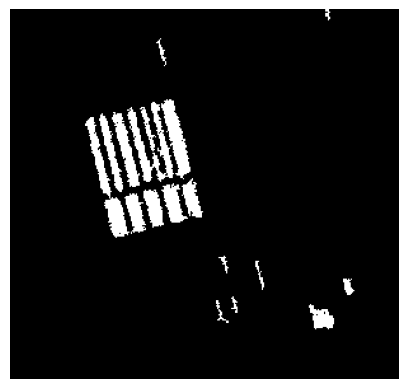

test run time: 23.7451 seconds


In [ ]:
model.eval()
outputs = np.zeros((ylen, xlen))
start_time = time.time()
for i in range(ylen):
    for j in range(xlen):
        if preclassify_lab[i, j] != 1.5:
            outputs[i, j] = preclassify_lab[i, j]
        else:
            img_patch = x_test[i * xlen + j, :, :, :]
            img_patch = img_patch.reshape(1, img_patch.shape[0], img_patch.shape[1], img_patch.shape[2])
            img_patch = torch.FloatTensor(img_patch).to(device)
            prediction = model(img_patch)
            prediction = np.argmax(prediction.detach().cpu().numpy(), axis=1)
            outputs[i, j] = prediction + 1

    if (i + 1) % 50 == 0:
        print('... ... row', i + 1, ' handling ... ...')

outputs = outputs - 1
res = outputs * 255
res = postprocess(res)
evaluate(im_gt, res)
plt.imshow(res, 'gray')
plt.axis('off')  # remove coordinate axis
plt.xticks([])  # remove x axis
plt.yticks([])  # remove y axis

plt.show()
end_time = time.time()
execution_time = end_time - start_time
print(f"test run time: {execution_time:.4f} seconds")

In [ ]:
### Yellow River - RESults with NO change in Loss Function
#  Change detection results ==>
#  ... ... FP:   1048
#  ... ... FN:   2169
#  ... ... OE:   3217
#  ... ... PCC:  95.67
#  ... ... KC:  84.89
# test run time: 52.2147 seconds
#try2
# ... ... FP:   1494
#  ... ... FN:   1882
#  ... ... OE:   3376
#  ... ... PCC:  95.45
#  ... ... KC:  84.48
#  test run time: 55.2307 seconds


### First change with Loss Function
#  Change detection results ==>
#  ... ... FP:   1534
#  ... ... FN:   1662
#  ... ... OE:   3196
#  ... ... PCC:  95.70
#  ... ... KC:  85.42
#  test run time: 62.7829 seconds
# try2
#  Change detection results ==>
#  ... ... FP:   1236
#  ... ... FN:   1783
#  ... ... OE:   3019
#  ... ... PCC:  95.94
#  ... ... KC:  86.06
# test run time: 57.5208 seconds

### farmland
#with no loss function
#  Change detection results ==>
#  ... ... FP:   417
#  ... ... FN:   755
#  ... ... OE:   1172
#  ... ... PCC:  98.68
#  ... ... KC:  87.81

#try2
#  Change detection results ==>
#  ... ... FP:   337
#  ... ... FN:   841
#  ... ... OE:   1178
#  ... ... PCC:  98.68
#  ... ... KC:  87.56

#try 3
#  Change detection results ==>
#  ... ... FP:   337
#  ... ... FN:   841
#  ... ... OE:   1178
#  ... ... PCC:  98.68
#  ... ... KC:  87.56

#with new loss function
#  Change detection results ==>
#  ... ... FP:   507
#  ... ... FN:   692
#  ... ... OE:   1199
#  ... ... PCC:  98.65
#  ... ... KC:  87.71

#try 2
#  Change detection results ==>
#  ... ... FP:   303
#  ... ... FN:   854
#  ... ... OE:   1157
#  ... ... PCC:  98.70
#  ... ... KC:  87.73